In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
from scipy.integrate import odeint
from scipy import stats
from EDMtoolkit import *
from modelSystems import *
import datetime

plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
AR_coefs = np.array([-3,2,6])
l = len(AR_coefs)

A = np.zeros((l,l))
A[0,:] = AR_coefs
A[1:,:-1] = np.identity(l-1)

In [3]:
X = np.zeros(200)
X[1] = rand.normal(1)

for i in range(200-1-l):
    X[i+1] = (A @ X[i:i+l])[0]

In [4]:
[X[1] * (np.exp(5j)) ** e for e in range(20)]

[(2.3755443100526374+0j),
 (0.6738520906542631-2.277967104447371j),
 (-1.9932515966247326-1.2923462545217572j),
 (-1.8046722988075365+1.544787578581658j),
 (0.9694170199753521+2.168741895755594j),
 (2.3546461998304493-0.3144074468702735j),
 (0.36643115409781957-2.347112902765864j),
 (-2.14676087584405-1.01716690418473j),
 (-1.5843409175155654+1.7700493287220547j),
 (1.2479256614814929+2.0213590261107592j),
 (2.2923195583785305-0.6232830908172614j),
 (0.05256308993800991-2.374962713517757j),
 (-2.262499236445498-0.7240911366029805j),
 (-1.3361340459760314+1.9641681649510507j),
 (1.5044778293387304+1.8384116051776003j),
 (2.1896609840784214-0.9211924575397794j),
 (-0.26222978900424293-2.3610265366535477j),
 (-2.3384303341634296-0.4182754371078559j),
 (-1.0644187292803586+2.1237286874223464j),
 (1.734559648172116+1.6231184787181991j)]

In [252]:
def rand_disc(n, minimum=0,maximum=1):
    return np.sign(rand.uniform(-1,1,size=n))*rand.uniform(minimum,maximum,size=n)
    # return np.exp(rand.uniform(size=n)*np.pi*2j)
    # return rand.uniform(minimum,maximum,size=n)*np.exp(rand.uniform(size=n)*np.pi*2j)

def calculate_coeff(roots):
    
    # contains the phi which satisfies (1-phi*z)=0 when z=root
    coefs_root_form = -1 / roots
    subset_sizes = range(1,len(coefs_root_form)+1)
    
    # sum all 1 element subsets, then 2 element subsets, ... n element subsets
    return np.array([np.sum(np.prod(np.array(list(itertools.combinations(coefs_root_form, subset_size))),axis=1)) for subset_size in subset_sizes])

    """
    for subset_size in range(1,len(roots)):
        subsets = np.array(list(itertools.combinations(coefs_root_form, subset_size)))
        products = np.sum(np.prod()
        print(subsets)
      
    return
    """
    
def eval_poly(coefs, value):
    return 1 + np.sum(coefs * (value ** np.arange(1,len(coefs)+1)))

In [253]:
np.set_printoptions(suppress=True, precision=3)

roots = rand_disc(6,2,3)
coefs = calculate_coeff(roots)

print(np.array(list([eval_poly(coefs,root) for root in roots])))

[0. 0. 0. 0. 0. 0.]


In [254]:


calculate_coeff(np.arange(1,5))

array([-2.083,  1.458, -0.417,  0.042])

In [329]:
tlen = 100
X = rand_disc(tlen)
l = 6

ar_roots = rand_disc(l,1.1,1.2)
ar_coeffs = -calculate_coeff(ar_roots)

for i in range(tlen-l):
    X[i+l] = np.sum(ar_coeffs * X[i:i+l])

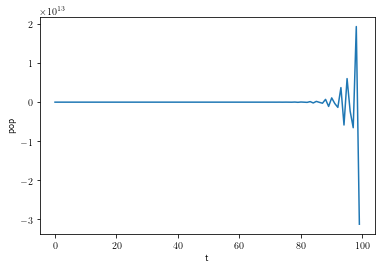

array([ 1.191, -1.116, -1.11 ,  1.198,  1.174,  1.141])

In [330]:
plotTS(X)
ar_roots